In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, tensor, qeye, sigmax, sigmaz,mesolve, fidelity

In [3]:
def P_j(j, N):
    op_list = [qeye(2) for _ in range(N)]
    op_list[j] = basis(2, 0) * basis(2, 0).dag()
    return tensor(op_list)

In [9]:
P_j(0,2)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [10]:
P_j(1,2)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

In [11]:
# Define the Pauli X operator at site j
def X_j(j, N):
    op_list = [qeye(2) for _ in range(N)]
    op_list[j] = sigmax()
    return tensor(op_list)

In [13]:
X_j(1, 2)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [20]:
# Define the Pauli Z operator at site j
def Z_j(j, N):
    op_list = [qeye(2) for _ in range(N)]
    op_list[j] = sigmaz()
    return tensor(op_list)

In [21]:
Z_j(1, 2)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]

In [22]:
def create_PXP_Hamiltonian(N, Omega_max):
    H_PXP = 0
    for j in range(N):
        P_j_minus = P_j((j - 1) % N, N)
        X_j_op = X_j(j, N)
        P_j_plus = P_j((j + 1) % N, N)
        H_PXP += P_j_minus * X_j_op * P_j_plus
    H_PXP *= -Omega_max
    return H_PXP

In [26]:
create_PXP_Hamiltonian(2, 0.5)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-0.  -0.5 -0.5 -0. ]
 [-0.5 -0.  -0.  -0. ]
 [-0.5 -0.  -0.  -0. ]
 [-0.  -0.  -0.  -0. ]]

To understand the difference between mesolve(), which uses the Hamiltonian and by explicitly creating the unitary matrix from the Hamiltonian using expm()

In [2]:
from qutip import *

def generate_operators(N):
    si = qeye(2)
    sx = sigmax()
    sz = sigmaz()
    p = (si - sz) / 2.0

    sx_list = []
    sz_list = []
    p_list = []

    for n in range(N):
        op_list = [si] * N

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

        op_list[n] = p
        p_list.append(tensor(op_list))

    return sx_list, sz_list, p_list

def create_PXP_Hamiltonian(N, Omega):
    sx_list, sz_list, p_list = generate_operators(N)

    H_PXP = 0
    for n in range(N - 2):
        H_PXP += Omega * p_list[n] * sx_list[n + 1] * p_list[n + 2]

    # Periodic Boundary Conditions (PBC)
    if N > 2:
        H_PXP += Omega * (p_list[N-2] * sx_list[N-1] * p_list[0] + p_list[N-1] * sx_list[0] * p_list[1])
    
    return H_PXP

def initial_Z2_state(N):
    return tensor([basis(2, i % 2) for i in range(N)])

In [10]:
# Function to evolve the state with time using mesolve
def evolve_state_mesolve(H, psi0, T, steps):
    tlist = np.linspace(0, T, steps)
    result = mesolve(H, psi0, tlist, [], [])
    return result.states, tlist

# Function to evolve the state with time using unitary operator
def evolve_state_unitary(H, psi0, T, steps):
    tlist = np.linspace(0, T, steps)
    dt = tlist[1] - tlist[0]
    U = (-1j * dt * H).expm()
    states = [psi0]
    for _ in range(steps - 1):
        states.append(U * states[-1])
    return states, tlist

In [4]:
# Function to compute fidelity
def fidelity(initial_state, evolved_states):
    return [np.abs(initial_state.overlap(state))**2 for state in evolved_states]

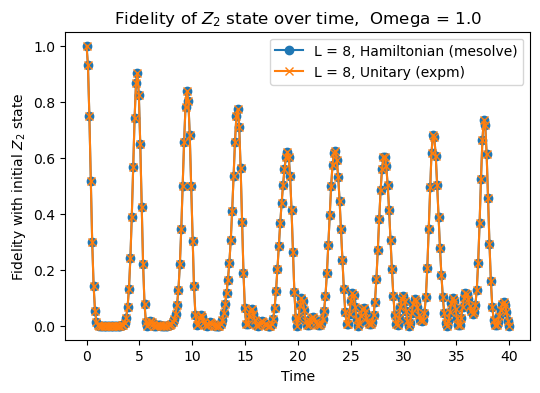

In [20]:
# Function to compute fidelity manually
def compute_fidelity(initial_state, evolved_states):
    return [np.abs(initial_state.overlap(state))**2 for state in evolved_states]
# Parameters
N = 8  # Number of qubits
Omega = 1.0  # Coupling strength
T = 40.0  # Total evolution time
steps = 300  # Number of time steps

# Hamiltonian and initial state
H_PXP = create_PXP_Hamiltonian(N, Omega)
Z2_state = initial_Z2_state(N)

# Evolve states using mesolve
evolved_states_mesolve, tlist_mesolve = evolve_state_mesolve(H_PXP, Z2_state, T, steps)

# Evolve states using unitary operator
evolved_states_unitary, tlist_unitary = evolve_state_unitary(H_PXP, Z2_state, T, steps)

# Compute fidelities
fidelities_mesolve = compute_fidelity(Z2_state, evolved_states_mesolve)
fidelities_unitary = compute_fidelity(Z2_state, evolved_states_unitary)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(tlist_mesolve, fidelities_mesolve, label='L = 8, Hamiltonian (mesolve)', marker='o')
plt.plot(tlist_unitary, fidelities_unitary, label='L = 8, Unitary (expm)', marker='x')
plt.xlabel('Time')
plt.ylabel('Fidelity with initial $Z_2$ state')
plt.title('Fidelity of $Z_2$ state over time,  Omega = 1.0')
plt.legend()
plt.show()